In [1]:
import os

import numpy as np
import pandas as pd
from typing import Dict, List
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

path = "./mkt_data/"
dir_list = os.listdir(path)
all_data = []
for rd in dir_list:
    # print('reading ', rd, '...')
    raw_data = pd.read_csv(path + '/' + rd)
    raw_data['ticker'] = str(rd)[:-4]
    all_data.append(raw_data)

# clean data column name
def cln_df(df: pd.DataFrame):
    cols: List[str] = df.columns
    for col in cols:
        if ' ' in col:
            col_name = col.strip()
            df[col_name] = df[col]
            del df[col]
    return df

all_data = [cln_df(data) for data in all_data]

/Users/jeffreychen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


convert timestamp to datetime object, easier for resample and groupping for analysis

In [2]:
def datetime_from_millis(millisec):
    return pd.Timestamp.fromtimestamp(millisec/1000) #.tz_localize('UTC').tz_convert('US/Eastern').strftime('%H:%M:%S.%f')[:-3] #depends on pd version
def convert_timestamp(df: pd.DataFrame):
    df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
    return df
all_data = [convert_timestamp(data) for data in all_data]

creating target columns for later usage

In [3]:
def get_target_cols(df:pd.DataFrame):
    df['non_cum_vol'] = df["volume"].diff().fillna(df['volume'].iloc[0])
    df['vol %'] = df['non_cum_vol']/(df['volume'].iloc[-1])
    df['spread'] = df['ask_price'] - df['bid_price']
    df['mid_price'] = (df['ask_price'] + df['bid_price'])/2
    df['time'] = pd.to_datetime(df['time'])
    return df


all_data = [get_target_cols(data) for data in all_data]

<h2>1.	Create a visualization to show the following in 15-minute intervals for each stock in the included data - </h2>

    a.	Average spread (Ask - Bid), 

    b.	Average total bin volume as a percent of the full day’s volume 

    c.	Volume-weighted average price (VWAP)

First, let create 15 minutes intervals data for plotting

In [4]:
def create_15min_agg_data(df:pd.DataFrame):
    try:
        data_15min = df.set_index('time').groupby(pd.Grouper(freq='15min')).agg({'spread': 'mean', 'vol %': 'mean', 'vwap': 'mean'})
        data_15min['ticker'] = df['ticker'].iloc[0]
        return data_15min
    except Exception as e:
        print('error at ticker', df['ticker'].iloc[0])
        print(e)
all_15min_data = [create_15min_agg_data(data) for data in all_data.copy()]

<h4> a. Average spread (Ask - Bid) Plot</h4>

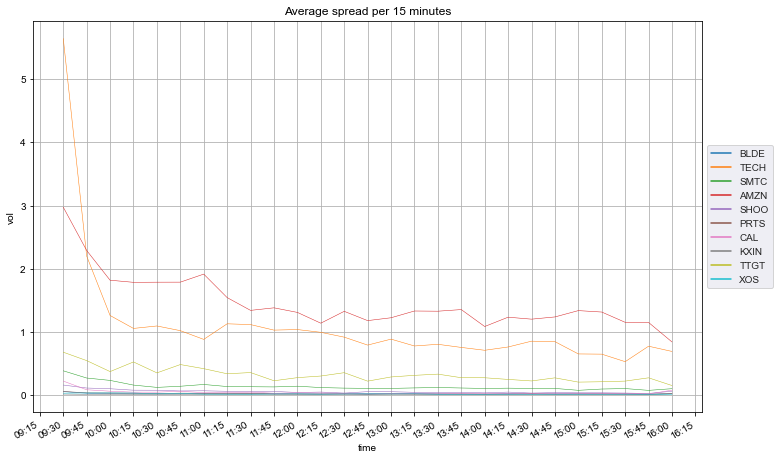

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.pyplot import subplot, subplots
from matplotlib import dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def plot_15min_spread(data_15min: List[pd.DataFrame]):
    meta_data = pd.concat(data_15min).reset_index()
    # meta_data['time'] = str(meta_data['time'].dt.time)
    fig,ax = subplots(figsize=(12, 8))
    sns.set_style("darkgrid")
    sns.lineplot(y = 'spread',
                x = 'time',
                hue='ticker',
                markers=True,
                lw=0.5,
                data=meta_data)
    ax.set(title='Average spread per 15 minutes', ylabel="vol")

    xformatter = mdates.DateFormatter('%H:%M')
    xlocator = mdates.MinuteLocator(byminute=[0,15, 30, 45], interval = 1) ##Set ticks to show 00 and 30 minutes only
    ## Set xtick labels to appear every 30 minutes
    ax.xaxis.set_major_locator(xlocator)

    ## Format xtick labels as HH:MM
    ax.xaxis.set_major_formatter(xformatter)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    ax.grid(True)
plot_15min_spread(all_15min_data)

<h4>    b.	Average total bin volume as a percent of the full day’s volume </h4>


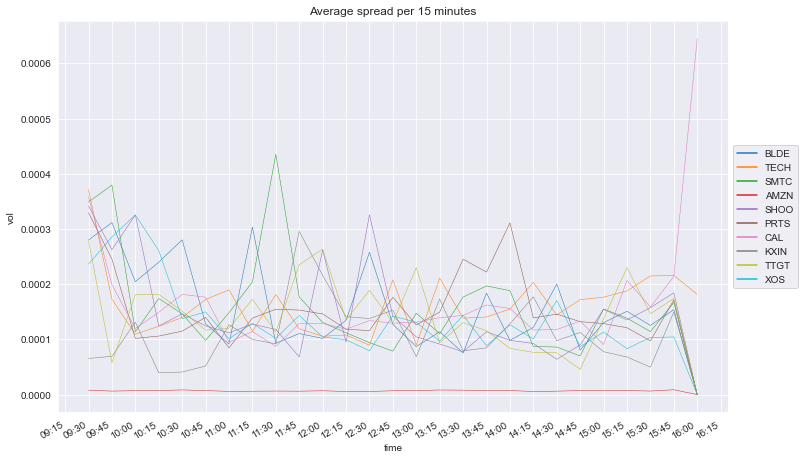

In [6]:

def plot_15min_volume(data_15min: List[pd.DataFrame]):
    meta_data = pd.concat(data_15min)
    fig,ax = subplots(figsize=(12, 8))
    sns.set_style("darkgrid")
    sns.lineplot(y = 'vol %',
                x = 'time',
                hue='ticker',
                markers=True,
                lw=.5,
                data=meta_data.reset_index())
    ax.set(title='Average spread per 15 minutes', ylabel="vol")

    xformatter = mdates.DateFormatter('%H:%M')
    xlocator = mdates.MinuteLocator(byminute=[0,15, 30, 45], interval = 1) ##Set ticks to show 00 and 30 minutes only
    ## Set xtick labels to appear every 30 minutes
    ax.xaxis.set_major_locator(xlocator)

    ## Format xtick labels as HH:MM
    ax.xaxis.set_major_formatter(xformatter)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    ax.grid(True)
plot_15min_volume(all_15min_data)

<h4>    c.	Volume-weighted average price (VWAP) </h4>


due to vwap value for each stock vary drastically, thus here presented individual graph instead of aggregate one 

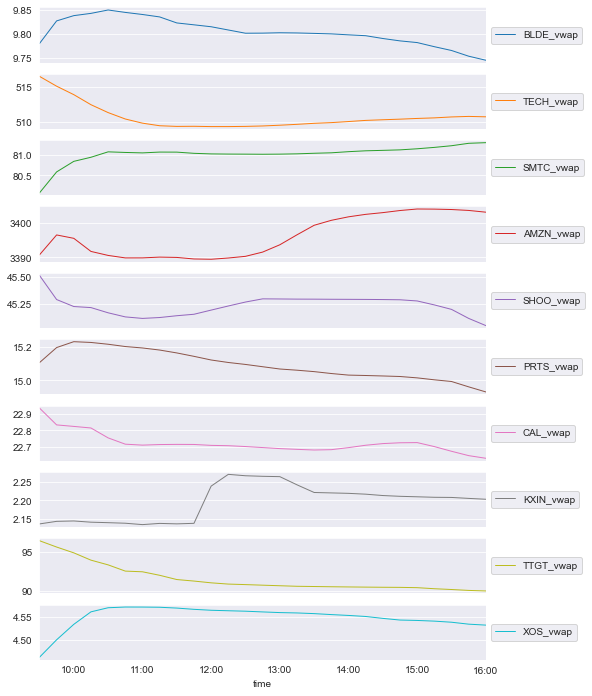

In [7]:
def plot_vwap(pdf):
    dats = pd.DataFrame()
    for data in pdf:
        if 'time' not in dats.columns:
            dats['time'] = data.index            
        ticker = data['ticker'].iloc[0]
        dats[ticker + '_vwap'] = data['vwap'].values
    dats = dats.set_index('time')
#     print(dats.head())
    cols_plot = list(dats.columns)
    axes = dats[cols_plot].plot(linewidth=1, figsize=(8, 12), subplots=True)
    for ax in axes:
        ax.set_ylabel('')
        ax.legend(loc='center left', bbox_to_anchor=(1, .5))

plot_vwap(all_15min_data)

<h2> Question 2 - Cross Sectional Regression</h2>



<h4> First step - Create Response Variable </h4>

Creating the required columns for future usage

In [8]:
from copy import deepcopy
all_data_2 = deepcopy(all_data) 

# Throw away observations where spread (ask price – bid price) is zero or negative. 
def create_model_variables(pdf:pd.DataFrame):    
    pdf['mid_price'] = (pdf['bid_price'] + pdf['ask_price'])/2
    pdf['denom'] = pdf['ask_price'] - pdf['bid_price']
    mask = pdf['denom'] > 0
    pdf = pdf[mask]
    pdf = pdf.reset_index(drop=True)
    return pdf

all_data_2 = [create_model_variables(df) for df in all_data_2]

Next, calculate the normalized mid price return from the time of trade to the midpoint price at 10 seconds after the time of a trade.
Since using built-in resample on 10s will result in aggregating the data, here I build an algo to retreive the proper t+10 midprice without losing any data.

In [9]:

from collections import deque
from typing import Deque

# runtime O(n)
def get_t_p_10_midprc(pdf: pd.DataFrame):
    time, midprcs = pdf['time'], pdf['mid_price']
    qt: Deque = deque([]) # we use queue we keep tracks the next t+10 time, initialized with deque here
    time_10 = [0]*len(time)
    price_10 = [0]*len(midprcs)
    prevt = time[0]
    prevp = midprcs[0]
    
    for idx, currt in enumerate(time):
        try:
            qt.append(idx) # using que to keep tracks on the idx of time that smaller than t+10
            
            # whenever theres a time larger than the que's (t+10), we find the 'next' t that larger than t+10
            while qt and currt > (time[qt[0]] + pd.Timedelta('10s')): 
                time_10[qt[0]] = prevt # thus, when we found time > t+10, we store the previous time 
                price_10[qt[0]] = prevp # store previous mid price
                qt.popleft()
            prevt = currt 
            prevp = midprcs[idx] 
        except Exception as e:
            print('err', e, end=',')
        
    # we might have left queue due to time already larger than the last time we have
    while qt: 
        time_10[qt[0]] = prevt
        price_10[qt[0]] = prevp
        qt.popleft()
    return time_10, price_10

# after getting the mid price t+10 series, we could calculate the rest and create our response data
def create_respond_data(pdf:pd.DataFrame):
    timep10, prcp10 = get_t_p_10_midprc(pdf)
    respond = pdf.copy()
    # respond['timep10'] = timep10 ; unmark to check the t+10s time
    respond['prcp10'] = prcp10
    respond['mid_prc_ret'] = (respond['mid_price']/respond['prcp10']) -  1
    respond['returns'] = respond['mid_prc_ret']/respond['denom']
    respond['time'] = respond['time']
    # pdf.drop(columns=['timep10','prcp10','mid_prc_ret','denom'], inplace=True)
    respond = respond[['time', 'returns']]
    return respond



respond_data = [create_respond_data(df) for df in all_data_2]



<h4> Second step - Create Predictors </h4>
Creating the following predictors for modelling

- Bid Offer Imbalance, calculated as (Nbb_agg_size – Nbo_agg_size )/(Nbb_agg_size + Nbo_agg_size) 

- Trade sign:  <br>
        1 if the last trade price is above the average of bid and ask price <br>
        -1 if the last trade price is below the average of bid and ask price

- Trade Size imbalance over the last 10 seconds: Trade size imbalance for any period can be calculated as: 
        Sum ( Trade Sign x Trade Size ) 


In [10]:
def create_predictors(pdf:pd.DataFrame, label=False):
    predictor = pd.DataFrame(index=pdf.index)
    predictor['time'] = pdf['time']
    
    ## Bid Offer Imbalance Creation
    predictor['bid_offer_imbal'] = (pdf['nbb_agg_size'] - pdf['nbo_agg_size'])/(pdf['nbb_agg_size'] + pdf['nbo_agg_size'])
    
    ## Trade Sign Creation
    predictor['trade_sign'] = np.where(pdf['trade_price'] > pdf['mid_price'], 1, 0)
    predictor['trade_sign2'] = np.where(pdf['trade_price'] < pdf['mid_price'], -1, 0)
    predictor['trade_sign'] = predictor['trade_sign'] + predictor['trade_sign2']

    ## Trade Size imbalance over last 10 seconds
    predictor['trade_sz_imbal'] = predictor['trade_sign']*pdf['trade_size']
    predictor['trade_sz_imbal_10s'] = predictor.set_index('time')['trade_sz_imbal'].rolling('10s').sum().values

    ## get ticker and timestamp for grouping
    predictor['ticker'] = pdf['ticker']
    
    predictor.drop(columns=['trade_sign2', 'trade_sz_imbal'], axis=1, inplace=True)

    if not label:
        return predictor[['time', 'bid_offer_imbal', 'trade_sign', 'trade_sz_imbal_10s']]
        
    return predictor

predictors = [create_predictors(data) for data in all_data_2]

aggregate responses and predictors for modelling

In [11]:
agg_predictors = pd.concat(predictors).set_index('time')
# agg_predictors.index = agg_predictors.index.strftime('%H:%M:%S:%f')
agg_response = pd.concat(respond_data).set_index('time')
# agg_response.index = agg_response.index.strftime('%H:%M:%S:%f')

Here we use linear regression model from sklearn as base class. It gives a flexibility to build more statistic objects on it 

In [12]:
from sklearn import linear_model
from scipy.stats import t as scpt
import numpy as np

from sklearn.linear_model import LinearRegression

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        mse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        self.se = np.array([
            np.sqrt(np.diagonal(mse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(mse.shape[0])
                    ])

        self.t = self.coef_ / self.se
        self.p = 2 * (1 - scpt.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        self.residual = self.predict(X) - y
        return self
    

In [13]:
# initialize date range for looping
# start_time_range = pd.date_range("2021-10-27 09:30:00", "2021-10-27 15:59:50", freq="10s").time
# end_time_range = pd.date_range("2021-10-27 09:30:10", "2021-10-27 16:00:00", freq="10s").time
predictor_gp = agg_predictors.groupby(pd.Grouper(freq='10s'))
response_gp = agg_response.groupby(pd.Grouper(freq='10s'))
betas = []
stats = []
residuals = []
for (n1, X), (n2, y) in zip(predictor_gp, response_gp): # since just linear model, we loop thru all time interval and run regression
    # if ind/100 == ind//100:
    #     print("running", ind, end=',') # keep tracks the batch runner
    # X = agg_predictors.loc[start:end] # use the date range to select time periods, pd Datetimeindex has good performance
    # y = agg_response.loc[start:end]
    ols = LinearRegression()
    reg = ols.fit(X, y)
    betas.append(reg.coef_)
    stats.append((
        reg.t,
        reg.p,
        reg.se,
        ))
    residuals.append(reg.residual)
    


Lets check the coefficient and the statistic we applied

check coefficients

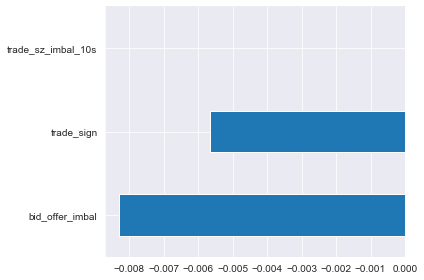

In [24]:
end_time_range = pd.date_range("2021-10-27 09:30:00", "2021-10-27 16:00:00", freq="10s").time

coef_sum = pd.DataFrame([b.tolist()[0] for b in betas], 
                       index=end_time_range,
                       columns=['bid_offer_imbal','trade_sign','trade_sz_imbal_10s'])
coef_sum.mean().plot.barh()
sns.despine()
plt.tight_layout()

statistic summary

In [40]:
print("Summary : ")
beta_summary = pd.DataFrame({
    'Mean Return':coef_sum.mean().values, 
    'Std Dev': coef_sum.std().values, 
    'Sharp Ratio':coef_sum.mean()/coef_sum.std()}, 
                       )
print(beta_summary)


Summary : 
                    Mean Return   Std Dev  Sharp Ratio
bid_offer_imbal       -0.008304  0.067198    -0.123570
trade_sign            -0.005672  0.037572    -0.150967
trade_sz_imbal_10s    -0.000004  0.000053    -0.079769


In [26]:
tstats1 = np.mean([t[0].tolist()[0] for t in stats], axis=0)
pstats = np.mean([t[1].tolist()[0] for t in stats], axis=0)
stderr = np.mean([t[2].tolist()[0] for t in stats], axis=0)

print('statistic summary: ')
stats_sum = pd.DataFrame([tstats1, pstats, stderr], 
                       index=['t statistic', 'p value', 'standard error'],
                       columns=['bid_offer_imbal','trade_sign','trade_sz_imbal_10s'])
print(stats_sum)

statistic summary: 
                bid_offer_imbal  trade_sign  trade_sz_imbal_10s
t statistic           -1.357984   -1.467850           -0.383953
p value                0.220367    0.258368            0.290972
standard error         0.006566    0.003004            0.000006


We can see that all coefficient are negative, and trade_sz_imbal_10s has almost zero explained power over the model.<br>
the t-stats are pretty small and p value are quite large, indicate our dependend variable is not significant enough ?

In [27]:
from linearmodels.panel import PanelOLS, FamaMacBeth
from patsy              import dmatrices

In [ ]:
# Then, the pre-programmed
predictors2 = [create_predictors(data, label=True) for data in all_data_2]
agg_predictors2 = pd.concat(predictors2).set_index('time')
agg_predictors2['returns'] = agg_response['returns']
agg_predictors2.index = agg_predictors2.index.round('10s')
agg_predictors2 = agg_predictors2.reset_index()
agg_predictors2 = agg_predictors2[['returns','bid_offer_imbal','trade_sign','trade_sz_imbal_10s','ticker','time']]
agg_predictors2 = agg_predictors2.set_index(['ticker','time'])

In [39]:
y, X  = dmatrices('returns~bid_offer_imbal+trade_sign+trade_sz_imbal_10s', agg_predictors2,return_type='dataframe')

res1 = FamaMacBeth(y,X).fit()
res1

Dep. Variable:,returns,R-squared:,0.0059
Estimator:,FamaMacBeth,R-squared (Between):,0.6070
No. Observations:,195107,R-squared (Within):,0.0027
Date:,"Thu, Oct 20 2022",R-squared (Overall):,0.0059
Time:,00:51:21,Log-likelihood,6.963e+04
Cov. Estimator:,Fama-MacBeth Standard Cov,,
,,F-statistic:,384.29
Entities:,10,P-value,0.0000
Avg Obs:,1.951e+04,Distribution:,"F(3,195103)"
Min Obs:,5982.0,,
Max Obs:,1.401e+05,F-statistic (robust):,47.721


from our model, we observed that the trade_sign and bid_offer_imbalance both shows significant result. However, both factors indicate negative returns in terms of profitability.

<h4> Model Improvement Analysis
</h4>

we can investigate on the residual of our model

In [74]:
res = []
for ind, (n, g) in enumerate(response_gp):
    r = residuals[ind].copy()
    r =r.rename(columns={'returns':'res'}).reset_index()
    r['returns'] = g['returns'].values
    res.append(r)
len(res)

2341

<AxesSubplot:xlabel='returns', ylabel='res'>

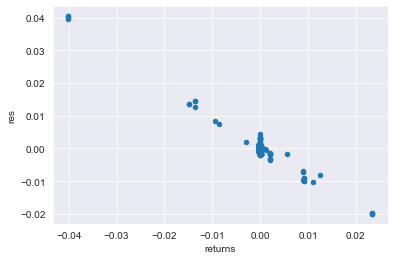

In [72]:
res[0].plot.scatter(x='returns', y='res')

<AxesSubplot:xlabel='returns', ylabel='res'>

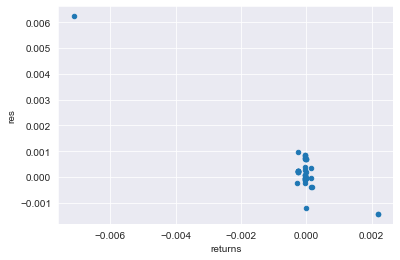

In [73]:
res[1000].reset_index().plot.scatter(x='returns',y='res')

<AxesSubplot:xlabel='returns', ylabel='res'>

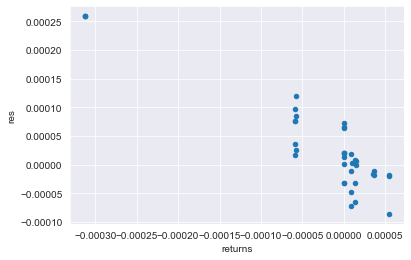

In [76]:
res[800].reset_index().plot.scatter(x='returns',y='res')

we randomly pick few point of time to check the residual vs fitted value. We could observed that few condition that are not idea for our model. Theres outlier inline with our data, and also from figure suggests that the error variances are not equal from time to time. To improve our model, we can truncate our model to make our depend variable more standardize and could avoid outlier in our model to avoid overfitting. We can also use do more robust testing on Heteroscedasticity by using tools like HAC estimator and white std error to further update our predictors, either tranform the feature or drop it. 



4.	Calculate the 15-second volatility (standard deviation of mid price returns) for SHOO in each 30 minute interval. Present the volatility in annualized terms. 

In [85]:
shoo_data = pd.read_csv(path+'SHOO.csv')
shoo_data = cln_df(shoo_data)
shoo_data = convert_timestamp(shoo_data)
shoo_data = get_target_cols(shoo_data)
shoo_data = create_model_variables(shoo_data)

In [ ]:
import math
## calculating mid price return
shoo_data['mid_prc_ret'] = shoo_data['mid_price'].pct_change(1)
shoo_data = shoo_data[['time','mid_prc_ret']]

## calculate the rolling 15 seconds volatility for each 30 minutes interval
gp = shoo_data.set_index('time').groupby(pd.Grouper(freq='30Min')) 
vol15 = []
intervals = []
for t, g in gp:
    # print(g)
    series = g.rolling('15s')['mid_prc_ret'].std().fillna(0)
    # print(series)
    interval = len(series)*[t]
    vol15.extend(series)
    intervals.extend(interval)
# print(vol15)
shoo_data['15 sec volatility'] = np.array(vol15)*math.sqrt(390*252)
shoo_data['intervals'] = intervals

<bound method _AxesBase.grid of <AxesSubplot:title={'center':'15 seconds volatility every 30 minutes'}, xlabel='time', ylabel='vol'>>

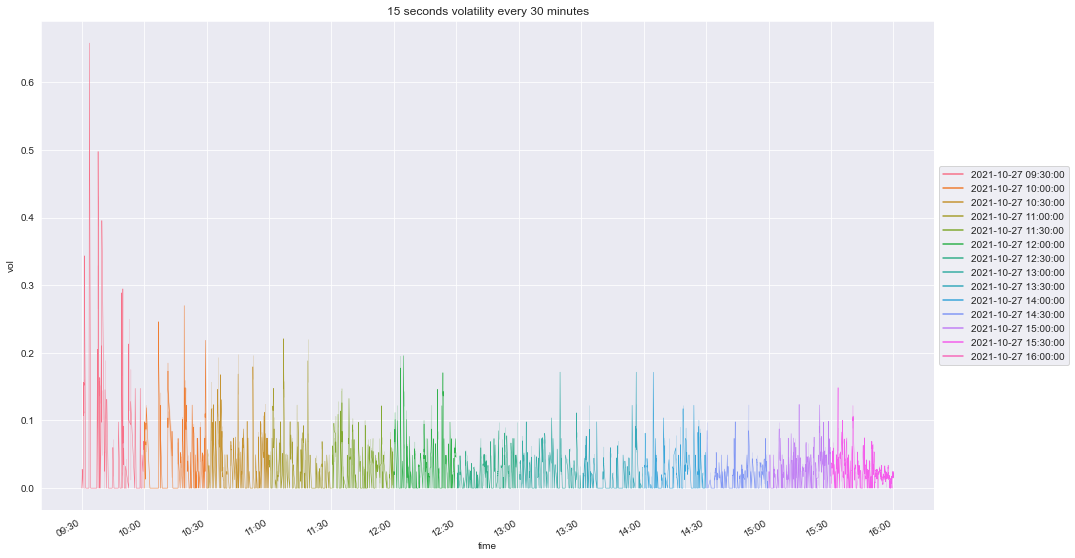

In [109]:
from matplotlib import dates as mdates
from matplotlib.pyplot import subplot, subplots

# sns.set_theme()
fig,ax = subplots(figsize=(16, 10))
sns.lineplot(y = '15 sec volatility',
 x = 'time',
 hue='intervals',
 data=shoo_data,
 lw=.5
 )
ax.set(title='15 seconds volatility every 30 minutes', ylabel="vol")

xformatter = mdates.DateFormatter('%H:%M')
xlocator = mdates.MinuteLocator(byminute=[0,30], interval = 1) ##Set ticks to show 00 and 30 minutes only

## Set xtick labels to appear every 30 minutes
ax.xaxis.set_major_locator(xlocator)

## Format xtick labels as HH:MM
ax.xaxis.set_major_formatter(xformatter)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate()
ax.grid


We can observe that during the Market On Openm mid price return volatility has the highest variance, and the variance starting to decrease along with the trading hour goes.
We can take a step further for volatility analysis. In the variance calculation, which is equal weighting squared deviation, we can further weight based off of volume, or off of sqrt/log voume so could aviod overweight observations that have a lot more volume. 